In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn import preprocessing
sns.set()

Для начала изучим и немного преобразуем наши данные. 

In [2]:
Train = pd.read_csv('train.csv')
Test = pd.read_csv('test.csv')

In [3]:
Train

id   timestamp  full_sq  life_sq  floor  max_floor  material  \
0          1  2011-08-20       43     27.0    4.0        NaN       NaN   
1          2  2011-08-23       34     19.0    3.0        NaN       NaN   
2          3  2011-08-27       43     29.0    2.0        NaN       NaN   
3          4  2011-09-01       89     50.0    9.0        NaN       NaN   
4          5  2011-09-05       77     77.0    4.0        NaN       NaN   
...      ...         ...      ...      ...    ...        ...       ...   
30466  30469  2015-06-30       44     27.0    7.0        9.0       1.0   
30467  30470  2015-06-30       86     59.0    3.0        9.0       2.0   
30468  30471  2015-06-30       45      NaN   10.0       20.0       1.0   
30469  30472  2015-06-30       64     32.0    5.0       15.0       1.0   
30470  30473  2015-06-30       43     28.0    1.0        9.0       1.0   

       build_year  num_room  kitch_sq  ...  cafe_count_5000_price_2500  \
0             NaN       NaN       NaN  ...                           9   
1             NaN       NaN       NaN  ...                          15   
2             NaN       NaN       NaN  ...                          10   
3             NaN       NaN       NaN  ...                          11   
4             NaN       NaN       NaN  ...                         319   
...           ...       ...       ...  ...                         ...   
30466      1975.0       2.0       6.0  ...                          15   
30467      1935.0       4.0      10.0  ...                         313   
30468         NaN       1.0       1.0  ...                           1   
30469      2003.0       2.0      11.0  ...                          22   
30470      1968.0       2.0       6.0  ...                           5   

      cafe_count_5000_price_4000 cafe_count_5000_price_high  \
0                              4                          0   
1                              3                          0   
2                              3                          0   
3                              2                          1   
4                            108                         17   
...                          ...                        ...   
30466                          5                          0   
30467                        128                         24   
30468                          1                          0   
30469                          1                          1   
30470                          2                          0   

       big_church_count_5000  church_count_5000  mosque_count_5000  \
0                         13                 22                  1   
1                         15                 29                  1   
2                         11                 27                  0   
3                          4                  4                  0   
4                        135                236                  2   
...                      ...                ...                ...   
30466                     15                 26                  1   
30467                     98                182                  1   
30468                      2                 12                  0   
30469                      6                 31                  1   
30470                      7                 16                  0   

       leisure_count_5000  sport_count_5000  market_count_5000  price_doc  
0                       0                52                  4    5850000  
1                      10                66                 14    6000000  
2                       4                67                 10    5700000  
3                       0                26                  3   13100000  
4                      91               195                 14   16331452  
...                   ...               ...                ...        ...  
30466                   2                84                  6    7400000  
30467                  82 

Разделим данные для обучения на объясняющие (X_train), тестовую выборку (X_test).
Нашим Y является цена на конкретную квартиру (переменная price_doc).
Также начнем работу с данными. Прежде всего, поработаем с пропущенными и пустыми значениями, а также неинформативными признаками и сильно коррелирующими (>=abs(0.85)). Так, например, неинформативным можно признать id наблюдения

In [4]:
X_train = Train
X_train = X_train.drop(['id'], 1)
X_test = Test
X_train

timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0      2011-08-20       43     27.0    4.0        NaN       NaN         NaN   
1      2011-08-23       34     19.0    3.0        NaN       NaN         NaN   
2      2011-08-27       43     29.0    2.0        NaN       NaN         NaN   
3      2011-09-01       89     50.0    9.0        NaN       NaN         NaN   
4      2011-09-05       77     77.0    4.0        NaN       NaN         NaN   
...           ...      ...      ...    ...        ...       ...         ...   
30466  2015-06-30       44     27.0    7.0        9.0       1.0      1975.0   
30467  2015-06-30       86     59.0    3.0        9.0       2.0      1935.0   
30468  2015-06-30       45      NaN   10.0       20.0       1.0         NaN   
30469  2015-06-30       64     32.0    5.0       15.0       1.0      2003.0   
30470  2015-06-30       43     28.0    1.0        9.0       1.0      1968.0   

       num_room  kitch_sq  state  ... cafe_count_5000_price_2500  \
0           NaN       NaN    NaN  ...                          9   
1           NaN       NaN    NaN  ...                         15   
2           NaN       NaN    NaN  ...                         10   
3           NaN       NaN    NaN  ...                         11   
4           NaN       NaN    NaN  ...                        319   
...         ...       ...    ...  ...                        ...   
30466       2.0       6.0    3.0  ...                         15   
30467       4.0      10.0    3.0  ...                        313   
30468       1.0       1.0    1.0  ...                          1   
30469       2.0      11.0    2.0  ...                         22   
30470       2.0       6.0    2.0  ...                          5   

      cafe_count_5000_price_4000  cafe_count_5000_price_high  \
0                              4                           0   
1                              3                           0   
2                              3                           0   
3                              2                           1   
4                            108                          17   
...                          ...                         ...   
30466                          5                           0   
30467                        128                          24   
30468                          1                           0   
30469                          1                           1   
30470                          2                           0   

       big_church_count_5000  church_count_5000  mosque_count_5000  \
0                         13                 22                  1   
1                         15                 29                  1   
2                         11                 27                  0   
3                          4                  4                  0   
4                        135                236                  2   
...                      ...                ...                ...   
30466                     15                 26                  1   
30467                     98                182                  1   
30468                      2                 12                  0   
30469                      6                 31                  1   
30470                      7                 16                  0   

       leisure_count_5000  sport_count_5000  market_count_5000  price_doc  
0                       0                52                  4    5850000  
1                      10                66                 14    6000000  
2                       4                67                 10    5700000  
3                       0                26                  3   13100000  
4                      91               195                 14   16331452  
...                   ...               ...                ...        ...  
30466                   2                84                  6    7400000  
30467                  8

In [5]:
X_train.state

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
30466    3.0
30467    3.0
30468    1.0
30469    2.0
30470    2.0
Name: state, Length: 30471, dtype: float64

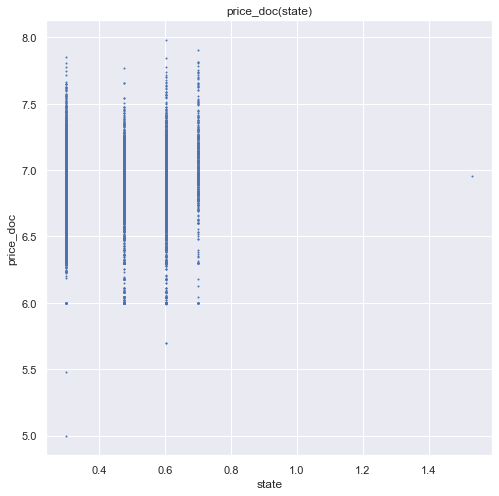

In [6]:
plt.figure(figsize=(8,8))
plt.scatter( np.log10(X_train['state']+1), np.log10(X_train['price_doc']) , s= 1)
plt.xlabel('state')
plt.ylabel('price_doc')
plt.title("price_doc(state)" )
plt.show()

Построим корреляционную матрицу, чтобы найти признаки с высокой степенью корреляции и убрать их из рассмотрения

In [7]:
corr_matrix = X_train.corr()
corr_matrix

full_sq   life_sq     floor  max_floor  material  \
full_sq             1.000000  0.161112  0.089649   0.119225  0.032866   
life_sq             0.161112  1.000000  0.045090   0.042442  0.011393   
floor               0.089649  0.045090  1.000000   0.454488 -0.009043   
max_floor           0.119225  0.042442  0.454488   1.000000  0.045915   
material            0.032866  0.011393 -0.009043   0.045915  1.000000   
...                      ...       ...       ...        ...       ...   
mosque_count_5000   0.021568  0.009945 -0.012256  -0.058255  0.050355   
leisure_count_5000  0.030218  0.022737 -0.044236  -0.048664  0.044502   
sport_count_5000    0.001580 -0.014499 -0.102101  -0.099855  0.098482   
market_count_5000  -0.041254 -0.050337 -0.123843  -0.113341  0.076378   
price_doc           0.341840  0.165606  0.117447   0.094386  0.064047   

                    build_year  num_room  kitch_sq     state    area_m  ...  \
full_sq              -0.006041  0.695444  0.020026 -0.091348  0.056303  ...   
life_sq              -0.002401  0.191024  0.000633 -0.066633  0.061395  ...   
floor                 0.001192 -0.005657 -0.008457 -0.113906 -0.019448  ...   
max_floor            -0.000261 -0.014220  0.020345 -0.072161 -0.092954  ...   
material             -0.004402 -0.026924  0.038747 -0.034225  0.001182  ...   
...                        ...       ...       ...       ...       ...  ...   
mosque_count_5000     0.019631  0.062785  0.013183  0.091894 -0.086786  ...   
leisure_count_5000   -0.000830  0.058663 -0.006259 -0.003876 -0.195067  ...   
sport_count_5000      0.005978  0.089908  0.016866  0.194379 -0.416222  ...   
market_count_5000     0.007362  0.061674  0.026404  0.273385 -0.449849  ...   
price_doc             0.002161  0.476337  0.028718  0.121303 -0.166981  ...   

                    cafe_count_5000_price_2500  cafe_count_5000_price_4000  \
full_sq                               0.039083                    0.040059   
life_sq                               0.028735                    0.031551   
floor                                -0.034791                   -0.029636   
max_floor                            -0.040235                   -0.033662   
material                              0.050919                    0.043660   
...                                        ...                         ...   
mosque_count_5000                     0.529434                    0.492859   
leisure_count_5000                    0.986206                    0.975462   
sport_count_5000                      0.824139                    0.778770   
market_count_5000                     0.432265                    0.380154   
price_doc                             0.225566                    0.210354   

                    cafe_count_5000_price_high  big_church_count_5000  \
full_sq                               0.043560               0.026895   
life_sq                               0.034888               0.017845   
floor                                -0.022303              -0.044398   
max_floor                            -0.029525              -0.048235   
material                              0.044403               0.038480   
...                                        ...                    ...   
mosque_count_5000                     0.481481               0.502028   
leisure_count_5000                    0.948391               0.969029   
sport_count_5000                      0.753384               0.825883   
market_count_5000                     0.353270               0.482547   
price_doc                             0.214327               0.198827   

                    church_count_5000  mosque_count_5000  leisure_count_5000  \
full_sq                      0.028579           0.021568            0.030218   
life_sq                      0.018114           0.009945            0.022737   
floor                       -0.045614          -0.012256           -0.044236   
max_floor                   -0.048240          -0.058255     

In [8]:
na_udalenie = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
drop1 = [column for column in na_udalenie.columns if any(na_udalenie[column] >= 0.85)]
drop2 = [column for column in na_udalenie.columns if any(na_udalenie[column] <= -0.85)]
print(f'Удаление признаков с корреляцией >= 0.85 = {drop1}')
X_train.drop(drop1, axis=1, inplace = True)
print(f'Удаление признаков с корреляцией <= -0.85 = {drop2}')
X_train.drop(drop2, axis=1, inplace = True)

Удаление признаков с корреляцией >= 0.85 = ['children_preschool', 'children_school', 'school_quota', 'school_education_centers_raion', 'office_raion', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'build_count_panel', 'build_count_slag', 'build_count_mix', 'raion_build_count_with_builddate_info', 'build_count_1921-1945', 'build_count_after_1995', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk', 'school_km', 'park_km', 'railroad_station_walk_min', 'railroad_station_avto_km', 'railroad_station_avto_min', 'public_transport_station_min_walk', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'railroad_km', 'zd_vokzaly_avto_km', 'radiation_km', 'power_transmission_line_km', 'thermal_power_plant_

<ipython-input-8-f88afe54e766>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  na_udalenie = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


In [9]:
#сохраним в качестве исходных данных для последующих моледей
X_train_obrazec = X_train
X_test_obrazec = X_test

In [10]:
X_train.shape

(30471, 123)

Осталось 123 признака из 275 изначальных, то есть удалено более половины переменных, что указывает на то, что явно не все представленные факторы будут сильно влиять на ситуацию. Не забываем все действия проделывать и с выборкой для теста.

Теперь нужно преобразовать категориальные признаки и пустые значения.

Категориальные переменные будем преобразовывать, используя метод Target Encoding, заменяя соответствующее значение средним значением переменной price_per_m2 (та, что по идее является целевой переменной в условиях нашей задачи).

Пропущенные значения заменим на 0

In [11]:
not_num_train = pd.DataFrame(X_train.select_dtypes(include=['object'])).columns
not_num_train

Index(['timestamp', 'product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
       'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology'],
      dtype='object')

In [12]:
# это я делаю, чтобы самостоятельно руками не писать код, как циклом запустить пока не придумала
for i in not_num_train:
    print(f"X_train['{i}_encoding'] = code_mean(X_train,'{i}','full_sq')")
    
    print(f"X_test['{i}_encoding'] = code_mean(X_test,'{i}','full_sq')")

X_train['timestamp_encoding'] = code_mean(X_train,'timestamp','full_sq')
X_test['timestamp_encoding'] = code_mean(X_test,'timestamp','full_sq')
X_train['product_type_encoding'] = code_mean(X_train,'product_type','full_sq')
X_test['product_type_encoding'] = code_mean(X_test,'product_type','full_sq')
X_train['sub_area_encoding'] = code_mean(X_train,'sub_area','full_sq')
X_test['sub_area_encoding'] = code_mean(X_test,'sub_area','full_sq')
X_train['culture_objects_top_25_encoding'] = code_mean(X_train,'culture_objects_top_25','full_sq')
X_test['culture_objects_top_25_encoding'] = code_mean(X_test,'culture_objects_top_25','full_sq')
X_train['thermal_power_plant_raion_encoding'] = code_mean(X_train,'thermal_power_plant_raion','full_sq')
X_test['thermal_power_plant_raion_encoding'] = code_mean(X_test,'thermal_power_plant_raion','full_sq')
X_train['incineration_raion_encoding'] = code_mean(X_train,'incineration_raion','full_sq')
X_test['incineration_raion_encoding'] = code_mean(X_test,'inciner

In [13]:
def code_mean(data,cat_feature,real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

X_train['timestamp_encoding'] = code_mean(X_train,'timestamp','full_sq')
X_test['timestamp_encoding'] = code_mean(X_test,'timestamp','full_sq')
X_train['product_type_encoding'] = code_mean(X_train,'product_type','full_sq')
X_test['product_type_encoding'] = code_mean(X_test,'product_type','full_sq')
X_train['sub_area_encoding'] = code_mean(X_train,'sub_area','full_sq')
X_test['sub_area_encoding'] = code_mean(X_test,'sub_area','full_sq')
X_train['culture_objects_top_25_encoding'] = code_mean(X_train,'culture_objects_top_25','full_sq')
X_test['culture_objects_top_25_encoding'] = code_mean(X_test,'culture_objects_top_25','full_sq')
X_train['thermal_power_plant_raion_encoding'] = code_mean(X_train,'thermal_power_plant_raion','full_sq')
X_test['thermal_power_plant_raion_encoding'] = code_mean(X_test,'thermal_power_plant_raion','full_sq')
X_train['incineration_raion_encoding'] = code_mean(X_train,'incineration_raion','full_sq')
X_test['incineration_raion_encoding'] = code_mean(X_test,'incineration_raion','full_sq')
X_train['oil_chemistry_raion_encoding'] = code_mean(X_train,'oil_chemistry_raion','full_sq')
X_test['oil_chemistry_raion_encoding'] = code_mean(X_test,'oil_chemistry_raion','full_sq')
X_train['radiation_raion_encoding'] = code_mean(X_train,'radiation_raion','full_sq')
X_test['radiation_raion_encoding'] = code_mean(X_test,'radiation_raion','full_sq')
X_train['railroad_terminal_raion_encoding'] = code_mean(X_train,'railroad_terminal_raion','full_sq')
X_test['railroad_terminal_raion_encoding'] = code_mean(X_test,'railroad_terminal_raion','full_sq')
X_train['big_market_raion_encoding'] = code_mean(X_train,'big_market_raion','full_sq')
X_test['big_market_raion_encoding'] = code_mean(X_test,'big_market_raion','full_sq')
X_train['nuclear_reactor_raion_encoding'] = code_mean(X_train,'nuclear_reactor_raion','full_sq')
X_test['nuclear_reactor_raion_encoding'] = code_mean(X_test,'nuclear_reactor_raion','full_sq')
X_train['detention_facility_raion_encoding'] = code_mean(X_train,'detention_facility_raion','full_sq')
X_test['detention_facility_raion_encoding'] = code_mean(X_test,'detention_facility_raion','full_sq')
X_train['water_1line_encoding'] = code_mean(X_train,'water_1line','full_sq')
X_test['water_1line_encoding'] = code_mean(X_test,'water_1line','full_sq')
X_train['big_road1_1line_encoding'] = code_mean(X_train,'big_road1_1line','full_sq')
X_test['big_road1_1line_encoding'] = code_mean(X_test,'big_road1_1line','full_sq')
X_train['railroad_1line_encoding'] = code_mean(X_train,'railroad_1line','full_sq')
X_test['railroad_1line_encoding'] = code_mean(X_test,'railroad_1line','full_sq')
X_train['ecology_encoding'] = code_mean(X_train,'ecology','full_sq')
X_test['ecology_encoding'] = code_mean(X_test,'ecology','full_sq')

In [14]:
X_train = X_train.drop(not_num_train, 1)
X_test = X_test.drop(not_num_train, 1)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [15]:
X_train1 = X_train.drop(['price_doc'], 1)
X_test = X_test[X_train1.columns]

Для обучения напишем функцию для обучения модели, а также выводим статистику по модели

In [16]:
def train_model(train, features, target, k_samples):
    model = SGDRegressor()

    msle_list = []
    mse_list = []
    i = 0
    kfold = KFold(n_splits= k_samples, shuffle = True)

    for _, (train_index, val_index) in enumerate(kfold.split(train)):
        
        Ktrain = train.iloc[train_index, : ]
        Ktest = train.iloc[val_index, :  ]
        
        model.fit(X = Ktrain[features], y = Ktrain[target])
        test_predict = model.predict(Ktest[features])

        mse = mean_squared_error(test_predict, Ktest[target])
        msle = mean_squared_log_error(test_predict.clip(0.0001,), Ktest[target])

        msle_list.append(msle)
        mse_list.append(mse)
        i+=1
        print( f'Fold {i}: MSLE {msle} , MSE {mse}')
    msle_list = sum(msle_list)/len(msle_list)
    mse_list = sum(mse_list)/len(mse_list)
    print('Средний MSLE, средний MSE')
    return(msle_list, mse_list)


Представленные выше преобразования были для нашей первой модели. То есть
1) Сделали в качестве итоговой переменной цену за квартиру

2) Качественные признаки заменили средними значениями по переменной - общее количество квадратных метров

3) Все пропущенные значения заменили на 0
Смотрим на итоги модели

In [17]:
X_train1

full_sq  life_sq  floor  max_floor  material  build_year  num_room  \
0           43     27.0    4.0        0.0       0.0         0.0       0.0   
1           34     19.0    3.0        0.0       0.0         0.0       0.0   
2           43     29.0    2.0        0.0       0.0         0.0       0.0   
3           89     50.0    9.0        0.0       0.0         0.0       0.0   
4           77     77.0    4.0        0.0       0.0         0.0       0.0   
...        ...      ...    ...        ...       ...         ...       ...   
30466       44     27.0    7.0        9.0       1.0      1975.0       2.0   
30467       86     59.0    3.0        9.0       2.0      1935.0       4.0   
30468       45      0.0   10.0       20.0       1.0         0.0       1.0   
30469       64     32.0    5.0       15.0       1.0      2003.0       2.0   
30470       43     28.0    1.0        9.0       1.0      1968.0       2.0   

       kitch_sq  state        area_m  ...  oil_chemistry_raion_encoding  \
0           0.0    0.0  6.407578e+06  ...                     54.296239   
1           0.0    0.0  9.589337e+06  ...                     54.296239   
2           0.0    0.0  4.808270e+06  ...                     54.296239   
3           0.0    0.0  1.258354e+07  ...                     54.296239   
4           0.0    0.0  8.398461e+06  ...                     54.296239   
...         ...    ...           ...  ...                           ...   
30466       6.0    3.0  1.005305e+07  ...                     54.296239   
30467      10.0    3.0  7.307411e+06  ...                     54.296239   
30468       1.0    1.0  2.553630e+07  ...                     54.296239   
30469      11.0    2.0  6.050065e+06  ...                     54.296239   
30470       6.0    2.0  4.395333e+06  ...                     54.296239   

       radiation_raion_encoding  railroad_terminal_raion_encoding  \
0                     54.636429                         54.051133   
1                     54.636429                         54.051133   
2                     53.453132                         54.051133   
3                     54.636429                         54.051133   
4                     53.453132                         58.426937   
...                         ...                               ...   
30466                 53.453132                         54.051133   
30467                 53.453132                         58.426937   
30468                 54.636429                         54.051133   
30469                 53.453132                         54.051133   
30470                 53.453132                         54.051133   

       big_market_raion_encoding  nuclear_reactor_raion_encoding  \
0                      54.139318                       54.312855   
1                      54.139318                       54.312855   
2                      54.139318                       54.312855   
3                      54.139318                       54.312855   
4                      54.139318                       54.312855   
...                          ...                             ...   
30466                  54.139318                       54.312855   
30467                  54.139318                       54.312855   
30468                  54.139318                       54.312855   
30469                  54.139318                       54.312855   
30470                  54.139318                       54.312855   

       detention_facility_raion_encoding  water_1line_encoding  \
0                              54.249025               54.1179   
1                              54.249025               54.1179   
2                              54.249025               54.1179   
3                              54.249025               54.1179   
4                              54.249025               54.1179   
...                                  ...                   ...   
30466                          54.249025               54.1179   
30467  

In [18]:
features = X_train1.columns
target = 'price_doc'

In [19]:
msle, mse = train_model(X_train, features, target, 5)
print(msle, mse)

Fold 1: MSLE 427.30282782137584 , MSE 2.312354740409354e+44
Fold 2: MSLE 1400.7056226590435 , MSE 6.455260409740707e+46
Fold 3: MSLE 524.0671455940698 , MSE 1.1750137994259284e+44
Fold 4: MSLE 243.68279072832368 , MSE 2.486207373646644e+44
Fold 5: MSLE 1393.6726368690317 , MSE 5.118759416737516e+46
Средний MSLE, средний MSE
797.8862047343689 2.326751117122609e+46


In [20]:
model = SGDRegressor()
model.fit(X = X_train[features], y = X_train[target])
test_predict = model.predict(X_test[features])

write_submission = pd.read_csv('sample_submission.csv')
write_submission[target] = test_predict.clip(0.0001,)
write_submission.to_csv('predict.csv', index= False)

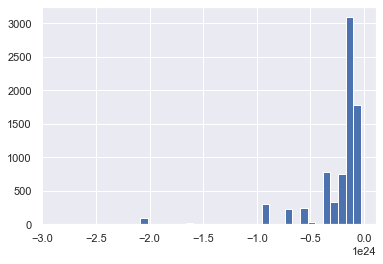

In [21]:
plt.hist(test_predict, bins =40)  #выводим полученный результат
plt.show()

Score по данной модели составил 37.91284


Попробуем еще одну модель с другими преобразованиями.
1) Возьмем в качестве таргета для модели цену за метр квадратный

2) Качественные признаки удалим из рассмотрения

3) Строки с пропущенными значениями также удалим, а в тестовой выборке - заменим 0

In [22]:
X_train2 = X_train_obrazec.copy()
X_test2 = X_test_obrazec.copy()

In [24]:
X_train2['price_per_m2'] = X_train2['price_doc']/(X_train2['full_sq']+1)
X_train2 = X_train2.drop(['price_doc'], 1)

X_train2.drop(not_num_train, axis=1, inplace=True)
X_test2.drop(not_num_train, axis=1, inplace=True)

X_train2 = X_train2.dropna()
X_test2 = X_test2.fillna(0)

In [25]:
X_train2.shape

(6042, 123)

Размеры нашей выборки сильно уменьшились, но мы тестируем разные модели, так что это может как сработать, так и ухудшить полученный результат

In [26]:
X_train1_2 = X_train2.drop(['price_per_m2'], 1)
features2 = X_train1_2.columns
target2 = 'price_per_m2'

msle, mse = train_model(X_train2, features2, target2, 5)
print(msle, mse)

Fold 1: MSLE 1580.624603117808 , MSE 1.0802657070564086e+45
Fold 2: MSLE 1605.3484557366446 , MSE 2.267309371815554e+45
Fold 3: MSLE 140.73889683829788 , MSE 2.952905211809115e+45
Fold 4: MSLE 1318.429582920017 , MSE 5.374454114945838e+43
Fold 5: MSLE 1661.81599757467 , MSE 1.1763390665010065e+46
Средний MSLE, средний MSE
1261.3915072374875 3.62352309936812e+45


Видим, что наша среднеквадратичная логарифмическая значительно увеличилась, но стоит проверить, как модель отработала на тестовых данных и получить результат на Kaggle

In [27]:
model2 = SGDRegressor()
model2.fit(X = X_train2[features2], y = X_train2[target2])
test_predict2 = model2.predict(X_test2[features2])
# наш test_predict умножим на площадь квартиры, чтобы получить итоговую стоимость
test_predict2 = test_predict2*X_test2.full_sq

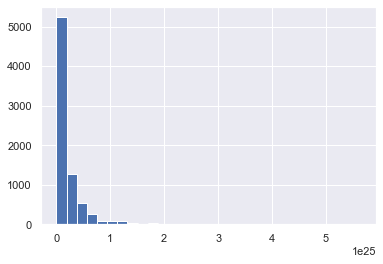

In [28]:
plt.hist(test_predict2, bins =30)  #выводим полученный результат
plt.show()

In [29]:
write_submission2 = pd.read_csv('sample_submission.csv')
write_submission2['price_doc'] = test_predict2.clip(0.0001,)
write_submission2.to_csv('predict2.csv', index= False)

Score составил 34.62918. Несмотря на то, что ошибка по модели увеличилась в 4 раза, score упал на 3 пункта
Но одназначно первая модель была лучше. Скорее всего, больше всего повлияло именно удаление пустых значений из тренировочной выборки

Протестируем еще 3 модель, уже с выбранными параметрами, а не всеми
1) Возьмем в качестве таргета цену за всю квартиру

2) Берем для обучения общую площадь квартиры, год постройки, а также все параметры, у которых в нейминге есть '_km'

3) Все пропущенные значения заменяем на 1

In [30]:
X_train3 = X_train_obrazec.copy()
X_test3 = X_test_obrazec.copy()

In [31]:
var_km = [item for item in X_train3.columns if '_km' in item]  # сохраните нужные названия столбцов сюда
var_km.append('full_sq')
var_km.append('build_year')

features3 = var_km
target3 = 'price_doc'

X_train3 = X_train3.fillna(1)
X_test3 = X_test3.fillna(1)

In [32]:
msle, mse = train_model(X_train3, features3, target3, 5)
print(msle, mse)

Fold 1: MSLE 262.6217641132266 , MSE 5.0715584194768764e+33
Fold 2: MSLE 249.33295993837763 , MSE 6.645100427878196e+31
Fold 3: MSLE 545.1985090907492 , MSE 7.176696293846751e+37
Fold 4: MSLE 244.20117885934826 , MSE 1.6152860245051991e+38
Fold 5: MSLE 499.9269520108246 , MSE 1.0055782639232461e+37
Средний MSLE, средний MSE
360.2562728025053 4.867129720752873e+37


Результат заметно улучшился. Обучаем модель и проверяем результат на Kaggle

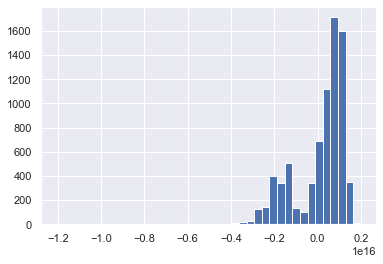

In [33]:
model3 = SGDRegressor()
model3.fit(X = X_train3[features3], y = X_train3[target3])
test_predict3 = model3.predict(X_test3[features3])

write_submission3 = pd.read_csv('sample_submission.csv')
write_submission3[target] = test_predict3.clip(0.0001,)
write_submission3.to_csv('predict3.csv', index= False)

plt.hist(test_predict3, bins =40) #выводим полученный результат
plt.show()

На Kaggle получен Score = 18.30489, самый низкий результат из всех полученных

Таким образом, самой лучшей можно признать первую модель